# Steel Defect Detection

##  Problem Definition
This is a project to use Severstal's steel defect data to do exploratory data analysis (EDA), model building and training, and comparison with deep learning. 
In this case, the technique we will be starting with is **Convolutional Neural Networks**. I think convolutional neural networks are a good starting place because they use convolutional layers to learn features like edges and textures that slide across the input.

Information about the data and Kaggle competition can be found at https://www.kaggle.com/competitions/severstal-steel-defect-detection/overview.
The goal will be to create a model that can localize and classify surface defects on a steel sheet. An algorithm that can do this could help engineers by automating and streamlining the process of detecting defects in the production process of flat sheet steel. 

### Dataset Information
The data is from the Kaggle competition. The data for this competition is a provided by the company Severstal. Images are labeled with a unique ImageId. The metric used by the company uses run-length encoding on the pixel values. The defects are described as pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3). he pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc. There are four possible defects, described by ClassID. ClassID can be 0, 1, 2, 3, or 4.

Alexey Grishin, BorisV, iBardintsev, inversion, Oleg. (2019). Severstal: Steel Defect Detection. Kaggle. https://kaggle.com/competitions/severstal-steel-defect-detection

In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from skimage import filters
from PIL import Image
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import optuna

In [2]:
# I'm going to split the training data into my train, test, and validation
# That will make it easier to test the accuracy of the model, since the provided test data doesn't have labels
# For now I'll keep the data together, until I finish data validation
labels = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
image_path = '../input/severstal-steel-defect-detection/train_images/'

In [3]:
# Find out how many labels and images there are
print(f"Count of Labels: {len(labels)}")
print(f"Count of images: {len(os.listdir(image_path))}")

Count of Labels: 7095
Count of images: 12568


I didn't expect there to be fewer labels than images. I'm going to guess that the images without defects aren't included in the label document. Let's look at the properties of the images and labels.

In [4]:
# Preview the DataFrame
print("Preview of labels DataFrame:")
print(labels.head())

# Check if the ClassID column contains any zeros
if (labels['ClassId'] == 0).any():
    print("ClassId column contains zeros.")
else:
    print("ClassId column does not contain any zeros.")

Preview of labels DataFrame:
         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...
ClassId column does not contain any zeros.


In [5]:
# Check if all images have the same pixel size
# List to store image sizes
image_sizes = []

# Iterate over all files in the image path
for image_file in os.listdir(image_path):
    full_image_path = os.path.join(image_path, image_file)
    
    # Check if the file is an image (should all be .jpg)
    if image_file.endswith(('.jpg')):
        with Image.open(full_image_path) as img:
            image_sizes.append(img.size)  # img.size returns a tuple (width, height)

# Check if all images have the same size
unique_sizes = set(image_sizes)
if len(unique_sizes) == 1:
    print(f"All images have the same size: {unique_sizes.pop()}")
else:
    print(f"Different image sizes found: {unique_sizes}")

All images have the same size: (1600, 256)


Now that we know how many images we have, and of what size and shape, and a little bit about how the labels work (with defect-free images being excluded from the dataset), let's hop into full EDA.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
I will view the data and determine if it needs cleaning and also see if I can make some general observations about the data.

In [3]:
# Get unique ClassIDs
unique_class_ids = labels['ClassId'].unique()

# To find defect-free images, we need to identify images not in labels
all_images = set(os.listdir(image_path))
label_images = set(labels['ImageId'])
defect_free_images = list(all_images - label_images)

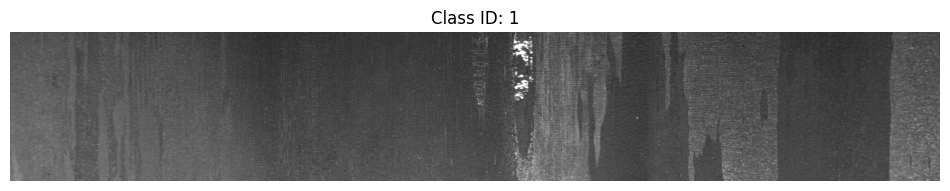

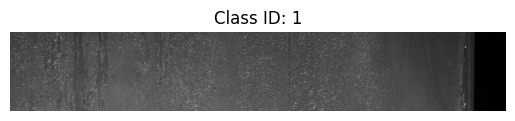

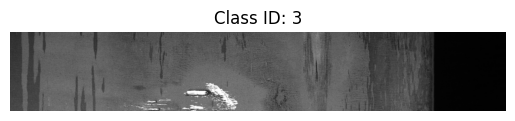

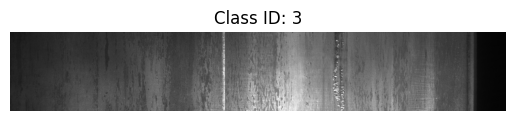

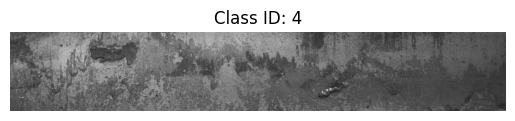

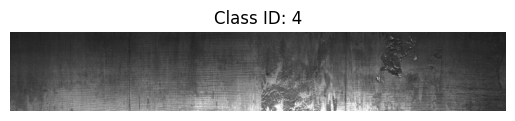

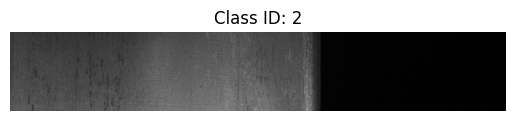

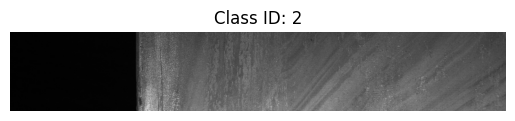

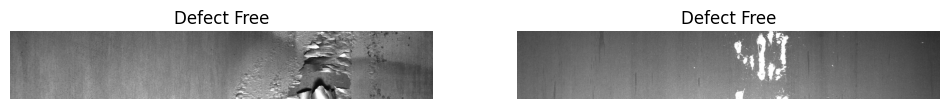

In [5]:
# Create a figure to display the images
plt.figure(figsize=(12, 8))
random.seed(42)

# Display two images for each ClassId
for class_id in unique_class_ids:
    # Filter the DataFrame for the current ClassId
    class_images = labels[labels['ClassId'] == class_id]['ImageId'].values
    
    # Randomly select two images from this class
    selected_images = random.sample(list(class_images), min(2, len(class_images)))
    
    # Display the images
    for image_name in selected_images:
        img_path = os.path.join(image_path, image_name)
        img = Image.open(img_path)
        
        plt.imshow(img)
        plt.title(f'Class ID: {class_id}')
        plt.axis('off')
        plt.show()

# Display two defect-free images
plt.figure(figsize=(12, 4))
for i, image_name in enumerate(random.sample(defect_free_images, 2)):
    img_path = os.path.join(image_path, image_name)
    img = Image.open(img_path)
    
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.title('Defect Free')
    plt.axis('off')

plt.show()

Looks like there's a bit of a black pixel problem with some of the images, will probably need to make an exception for that. I can't really verify that an image belongs in a particular class so I'm just going to trust that the labels are correct. It's also worth noting that the images are in grayscale.

At this moment the defect free one seems to have a ton of metal shavings on it so I'm not sure how trustworthy the non-labeled images are.. they may not be defect-free, and instead just unlabeled. Depending on how many there are it might seriously throw off the model.

In [7]:
# Check for duplicates
duplicates = labels.duplicated().any()
if duplicates:
    print("The labels DataFrame contains duplicates.")
else:
    print("The labels DataFrame does not contain duplicates.")

# Check for NaN values
nan_free = labels.isna().any().any()
if nan_free:
    print("The labels DataFrame contains NaN values.")
else:
    print("The labels DataFrame is free of NaN values.")

The labels DataFrame does not contain duplicates.
The labels DataFrame is free of NaN values.


Average pixel intensity for Class ID 1: 68.24226782226563
Average pixel intensity for Class ID 3: 100.33820629882813
Average pixel intensity for Class ID 4: 97.43756787109375
Average pixel intensity for Class ID 2: 44.6108935546875
Average pixel intensity for Defect Free Images: 75.61500439453125


<Figure size 1200x800 with 0 Axes>

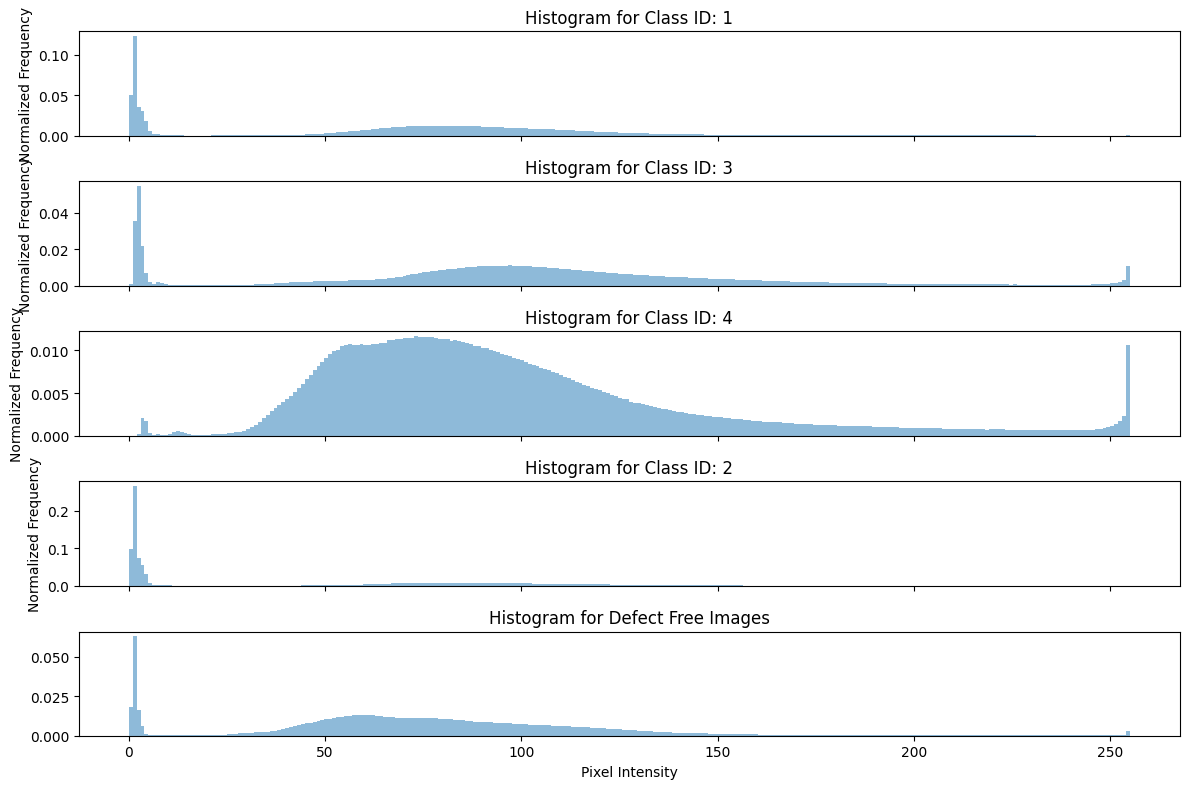

In [8]:
# Let's look at some histograms of pixel intensity of each of the classes.
# Initialize a list to store average intensities for each class
average_intensities = []

# Create a figure to display the histograms
plt.figure(figsize=(12, 8))

# Create subplots for each ClassId
num_classes = len(unique_class_ids)
fig, axes = plt.subplots(num_classes + 1, 1, figsize=(12, 8), sharex=True)

# Create histograms for each ClassId
for idx, class_id in enumerate(unique_class_ids):
    # Filter the DataFrame for the current ClassId and select up to 10 images
    class_images = labels[labels['ClassId'] == class_id]['ImageId'].values[:10]  # Limit to 10 images
    
    # Initialize a list to store pixel intensities for the current class
    pixel_values = []
    
    # Load and process each image in the current ClassId
    for image_name in class_images:
        img_path = os.path.join(image_path, image_name)
        img = Image.open(img_path)
        img_array = np.array(img)
        
        # Flatten the image array and collect pixel values
        pixel_values.extend(img_array.ravel())
        
    # Plot histogram for the current class
    axes[idx].hist(pixel_values, bins=256, alpha=0.5, density=True)
    
    # Calculate and store the average intensity for this class
    average_intensity = np.mean(pixel_values)
    average_intensities.append(average_intensity)
    
    axes[idx].set_title(f'Histogram for Class ID: {class_id}')
    axes[idx].set_ylabel('Normalized Frequency')

# Handle defect-free images, limiting to 10 images
defect_free_images_subset = defect_free_images[:10]  # Limit to 10 images
defect_free_intensities = []

for image_name in defect_free_images_subset:
    img_path = os.path.join(image_path, image_name)
    img = Image.open(img_path)
    img_array = np.array(img)
    
    # Collect pixel values for defect-free images
    defect_free_intensities.extend(img_array.ravel())

# Plot histogram for defect-free images
axes[-1].hist(defect_free_intensities, bins=256, alpha=0.5, density=True)

# Calculate average intensity for defect-free images
average_defect_free = np.mean(defect_free_intensities)

# Finalize the plot for defect-free images
axes[-1].set_title('Histogram for Defect Free Images')
axes[-1].set_xlabel('Pixel Intensity')

# Print average intensities
for idx, class_id in enumerate(unique_class_ids):
    print(f'Average pixel intensity for Class ID {class_id}: {average_intensities[idx]}')
print(f'Average pixel intensity for Defect Free Images: {average_defect_free}')

plt.tight_layout()
plt.show()

I'm pretty sure the CNN is going to have a hard time with these classes, excluding 4. I'm also thinking it'd be good to mask pixel values under some threshold, maybe 20. Let's see what the class distribution is.

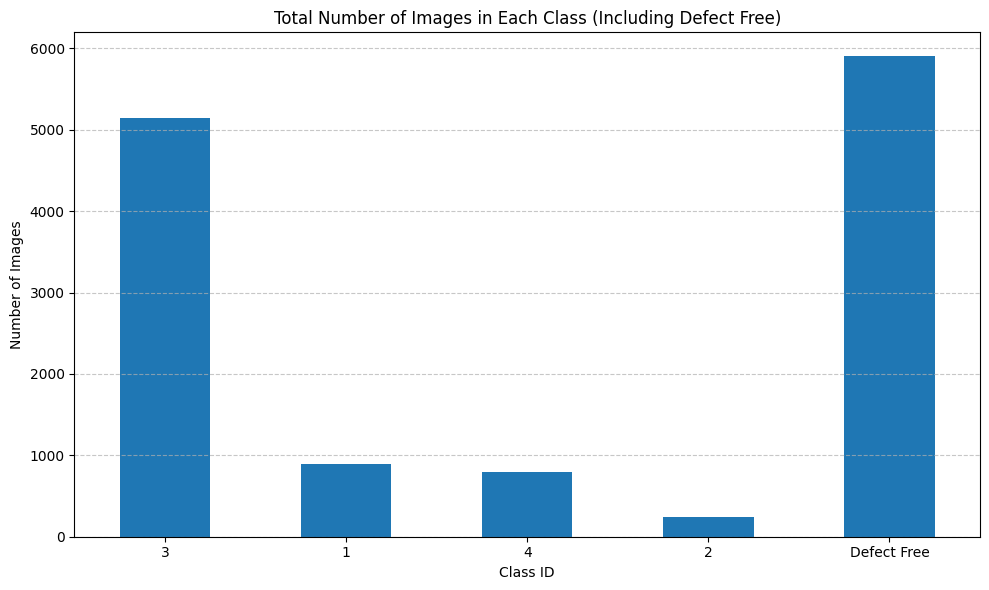

In [9]:
# Let's check for class imbalance
# Count the number of images for each ClassId
class_counts = labels['ClassId'].value_counts()

# Count the defect-free images
num_defect_free = len(defect_free_images)

# Create a Series for defect-free images
defect_free_series = pd.Series({'Defect Free': num_defect_free})

# Use pd.concat to combine class_counts with defect_free_series
class_counts_with_defect_free = pd.concat([class_counts, defect_free_series])

# Plotting
plt.figure(figsize=(10, 6))
class_counts_with_defect_free.plot(kind='bar')
plt.title('Total Number of Images in Each Class (Including Defect Free)')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The classes are quite imbalanced. I'm guessing the CNN is going to have a hard time predicting classes 1, 4, and 2. 

I'm going to go ahead and split the data into train, test, and validation sets. I am splitting the training data provided by the company so I have ClassIds for everything.

In [4]:
# Need to use the image path since the label set is missing the defect free images.
# Get the list of all image names in the directory
image_names = os.listdir(image_path)

# Create a DataFrame to store the image information
images_df = pd.DataFrame({'ImageId': image_names})

# Merge with labels DataFrame, assigning ClassId 0 to images without a ClassId
images_with_labels = pd.merge(images_df, labels[['ImageId', 'ClassId']], on='ImageId', how='left')
images_with_labels['ClassId'] = images_with_labels['ClassId'].fillna(0).astype(int)  # Assign ClassId 0 if missing

# Split the dataset into train, validation, and test sets (70% train, 15% validation, 15% test)
train, test = train_test_split(images_with_labels, test_size=0.3, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

# Count the number of images in each dataset by ClassId
train_counts = train['ClassId'].value_counts()
val_counts = val['ClassId'].value_counts()
test_counts = test['ClassId'].value_counts()

# Print the counts for each dataset
print("Train Set Class Counts:\n", train_counts)
print("\nValidation Set Class Counts:\n", val_counts)
print("\nTest Set Class Counts:\n", test_counts)

Train Set Class Counts:
 ClassId
0    4111
3    3618
1     635
4     567
2     166
Name: count, dtype: int64

Validation Set Class Counts:
 ClassId
0    879
3    793
1    131
4    107
2     40
Name: count, dtype: int64

Test Set Class Counts:
 ClassId
0    912
3    739
1    131
4    127
2     41
Name: count, dtype: int64


## Model Architecture
There were a few things discovered in EDA that are cause for concern. The classes are imbalanced, some images have a lot of black pixels as if they were misaligned, and some of the unlabeled images look like they have defects. I'm not really certain how well a simple CNN will do, but we will start there since it's less computationally expensive.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
## Parameters for model
num_epochs = 5
num_classes = 5
batch_size = 64
learning_rate = 0.001



In [6]:
# Here's a basic custom generator
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('L')  # 'L' mode is for grayscale
        img_np = np.array(image)
        # Apply the mask for pixel values below 25
        img_np[img_np < 25] = 0  # Set those pixel values to 0 (black)
        # Convert back to a PIL image (optional)
        image = Image.fromarray(img_np)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [7]:
# Load data in
trans_train = transforms.Compose([
    transforms.Resize((256, 128)),  # Resize to a smaller size, 256x128
    transforms.Pad(64, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # One value for grayscale
])

trans_valid = transforms.Compose([
    transforms.Resize((256, 128)),  # Resize to a smaller size
    transforms.Pad(64, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # One value for grayscale
])

dataset_train = MyDataset(df_data=train, data_dir=image_path, transform=trans_train)
dataset_valid = MyDataset(df_data=val, data_dir=image_path, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block: Conv2D -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 48 * 32, 128)  # Adjusted size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for multiclass classification

    def forward(self, x):
        # Apply first convolutional block
        x = self.pool(F.relu(self.conv1(x)))
        
        # Apply second convolutional block
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply third convolutional block
        x = self.pool(F.relu(self.conv3(x)))
        
        # Check shape after convolutions
        # print(f"Shape after convolutions: {x.shape}")
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 48 * 32)  # Reshape to (batch_size, flattened_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x  # Return logits for multiclass classification

In [19]:
# Let's prepare the model
model = SimpleCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store the average loss at each epoch
epoch_losses = []
validation_losses = []

total_step = len(loader_train)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(loader_train):

        images = images.to(device)
        labels = labels.to(device).long()  # Ensure labels are long
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  # Adjust for output shape
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)  # Accumulate loss
        
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(loader_train.dataset)
    epoch_losses.append(epoch_loss)  # Store the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

    # Validate the model and calculate validation loss
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in loader_valid:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).long()
            
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_images.size(0)

    val_epoch_loss = val_running_loss / len(loader_valid.dataset)
    validation_losses.append(val_epoch_loss)  # Store validation loss
    print(f'Validation Loss after Epoch [{epoch+1}/{num_epochs}]: {val_epoch_loss:.4f}')

Epoch [1/5], Step [100/143], Loss: 1.1421
Epoch [1/5], Average Loss: 1.0385
Validation Loss after Epoch [1/5]: 0.8173
Epoch [2/5], Step [100/143], Loss: 0.8085
Epoch [2/5], Average Loss: 0.7845
Validation Loss after Epoch [2/5]: 0.7536
Epoch [3/5], Step [100/143], Loss: 0.7612
Epoch [3/5], Average Loss: 0.7016
Validation Loss after Epoch [3/5]: 0.6541
Epoch [4/5], Step [100/143], Loss: 0.6246
Epoch [4/5], Average Loss: 0.6249
Validation Loss after Epoch [4/5]: 0.6147
Epoch [5/5], Step [100/143], Loss: 0.4271
Epoch [5/5], Average Loss: 0.5655
Validation Loss after Epoch [5/5]: 0.6446


## Results and Analysis
The simple 3 layer CNN seems like it was working okay. Let's look closer at the results and try some other methods and hyperparameters.

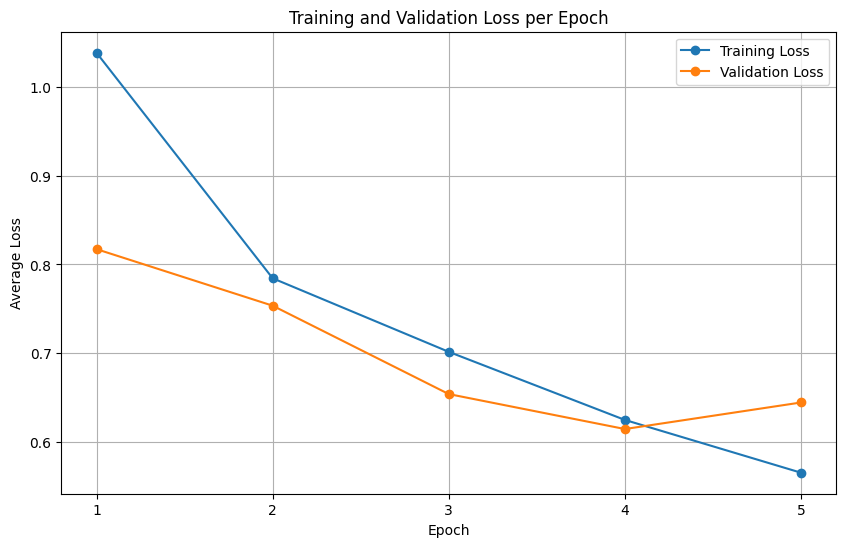

In [20]:
# After training, plot the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid()
plt.xticks(range(1, num_epochs + 1))  # Show every epoch on the x-axis
plt.show()

Looks like the first stab at epochs was more or less appropriate. Training could be stopped at the 4th epoch since the validation loss goes up. I want to test another deep learning method before deciding to optimize hyperparameters. U-Net is a different CNN that has a U-like shape, where the encoder and decoder are symmetrical. It also has skip connections. It's generally pretty good at segmenting medical data, and these images are kind of like diagnosing a medical condition.

In [12]:
# Define the convolutional layer with ReLU activation
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

# Define the U-Net model class
class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load the pre-trained ResNet model
        self.base_model = models.resnet18(weights=None)  # Remove pretrained weights
        self.base_model.load_state_dict(torch.load("../input/severstal-steel-defect-detection/resnet18-f37072fd.pth", weights_only=True))
        self.base_layers = list(self.base_model.children())

        # Modify the first layer to accept single-channel input
        self.base_layers[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Define the contracting path layers
        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer2 = self.base_layers[5]
        self.layer3 = self.base_layers[6]
        self.layer4 = self.base_layers[7]

        # Additional 1x1 convolutions
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        # Classifier
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.classifier = nn.Linear(512, num_classes)  # Output size based on the number of classes

    def forward(self, input):
        # Forward pass through the layers
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        # Use 1x1 convolutions
        layer4 = self.layer4_1x1(layer4)

        # Global Average Pooling
        x = self.pool(layer4)
        x = torch.flatten(x, 1)  # Flatten the output for the classifier

        # Classify
        out = self.classifier(x)

        return out


In [16]:
# Let's prepare the model
model = UNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store the average loss at each epoch
epoch_losses = []
validation_losses = []

total_step = len(loader_train)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device).long()
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images)
        # print("Output shape:", outputs.shape)
        loss = criterion(outputs, labels)  # Adjust for output shape
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)  # Accumulate loss
        
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(loader_train.dataset)
    epoch_losses.append(epoch_loss)  # Store the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

    # Validate the model and calculate validation loss
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in loader_valid:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).long()
            
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_images.size(0)

    val_epoch_loss = val_running_loss / len(loader_valid.dataset)
    validation_losses.append(val_epoch_loss)  # Store validation loss
    print(f'Validation Loss after Epoch [{epoch+1}/{num_epochs}]: {val_epoch_loss:.4f}')

Epoch [1/5], Step [100/143], Loss: 0.9789
Epoch [1/5], Average Loss: 1.1901
Validation Loss after Epoch [1/5]: 1.0851
Epoch [2/5], Step [100/143], Loss: 0.9651
Epoch [2/5], Average Loss: 1.0634
Validation Loss after Epoch [2/5]: 1.0216
Epoch [3/5], Step [100/143], Loss: 1.0063
Epoch [3/5], Average Loss: 1.0055
Validation Loss after Epoch [3/5]: 0.9658
Epoch [4/5], Step [100/143], Loss: 0.8295
Epoch [4/5], Average Loss: 0.9548
Validation Loss after Epoch [4/5]: 0.9169
Epoch [5/5], Step [100/143], Loss: 0.8771
Epoch [5/5], Average Loss: 0.9098
Validation Loss after Epoch [5/5]: 0.8814


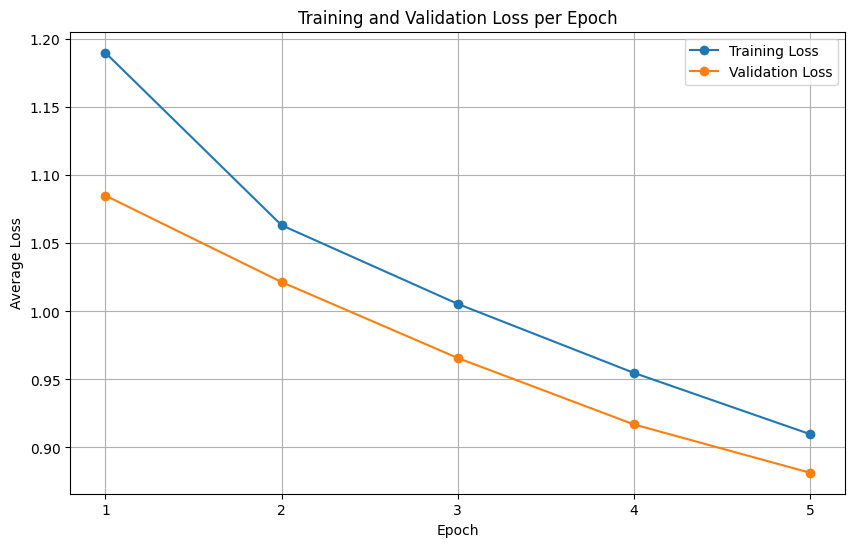

In [17]:
# After training, plot the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid()
plt.xticks(range(1, num_epochs + 1))  # Show every epoch on the x-axis
plt.show()

Looks like maybe I could add more epochs for this one. But so far it seems like the simple CNN is performing better, so I'll adjust the hyperparameters on it instead. I'm going to use Optuna, a framework for hyperparameter optimization.

In [14]:
def objective(trial):
    # Hyperparameters to optimize
    num_classes = 5 
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Batch size
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-1, log=True)  # Learning rate
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)  # Dropout rate

    # Initialize the model
    model = SimpleCNN(num_classes).to(device)  # Move model to the device
    model.dropout = nn.Dropout(dropout_rate)  # Set dropout rate

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
    loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

    # Training Loop
    for epoch in range(10):  # Adjust the number of epochs
        model.train()
        for images, labels in loader_train:
            # Move images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loader_valid:
            # Move images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()

    return val_loss / len(loader_valid)  # Return average validation loss

In [15]:
study = optuna.create_study(direction='minimize')  # Minimize validation loss
study.optimize(objective, n_trials=1)
print("Best hyperparameters:", study.best_params)

[I 2024-10-05 21:36:16,462] A new study created in memory with name: no-name-16f5fbdc-d594-47d2-9b2f-3a40495902c3
[I 2024-10-05 21:42:42,463] Trial 0 finished with value: 1.1473694954599654 and parameters: {'batch_size': 63, 'lr': 0.036652419262287954, 'dropout': 0.30773465579671433}. Best is trial 0 with value: 1.1473694954599654.


Best hyperparameters: {'batch_size': 63, 'lr': 0.036652419262287954, 'dropout': 0.30773465579671433}


Let's load up the model with the optimized hyperparameters and try it out on the test data.

In [16]:
best_params = study.best_params
best_batch_size = best_params['batch_size']
best_learning_rate = best_params['lr']
best_dropout_rate = best_params['dropout']

# Create the model using the best parameters
model = SimpleCNN(num_classes).to(device)
model.dropout = nn.Dropout(best_dropout_rate)  # Set the best dropout rate

# Optimizer with the best learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

# Lists to store the average loss at each epoch
epoch_losses = []
validation_losses = []

loader_train = DataLoader(dataset = dataset_train, batch_size=best_batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=best_batch_size//2, shuffle=False, num_workers=0)

total_step = len(loader_train)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device).long()
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images)
        # print("Output shape:", outputs.shape)
        loss = criterion(outputs, labels)  # Adjust for output shape
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)  # Accumulate loss
        
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(loader_train.dataset)
    epoch_losses.append(epoch_loss)  # Store the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

    # Validate the model and calculate validation loss
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_labels in loader_valid:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).long()
            
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_images.size(0)

    val_epoch_loss = val_running_loss / len(loader_valid.dataset)
    validation_losses.append(val_epoch_loss)  # Store validation loss
    print(f'Validation Loss after Epoch [{epoch+1}/{num_epochs}]: {val_epoch_loss:.4f}')

Epoch [1/5], Step [100/145], Loss: 1.1945
Epoch [1/5], Average Loss: 349.7120
Validation Loss after Epoch [1/5]: 1.1530
Epoch [2/5], Step [100/145], Loss: 1.2492
Epoch [2/5], Average Loss: 1.1650
Validation Loss after Epoch [2/5]: 1.1478
Epoch [3/5], Step [100/145], Loss: 1.3349
Epoch [3/5], Average Loss: 1.1618
Validation Loss after Epoch [3/5]: 1.1507
Epoch [4/5], Step [100/145], Loss: 1.1429
Epoch [4/5], Average Loss: 1.1595
Validation Loss after Epoch [4/5]: 1.1495
Epoch [5/5], Step [100/145], Loss: 1.0900
Epoch [5/5], Average Loss: 1.1600
Validation Loss after Epoch [5/5]: 1.1481


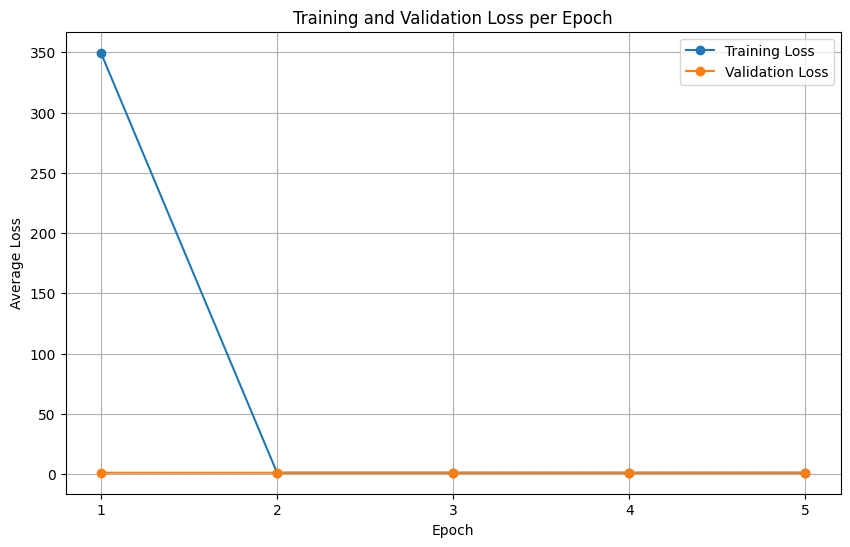

In [17]:
# After training, plot the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid()
plt.xticks(range(1, num_epochs + 1))  # Show every epoch on the x-axis
plt.show()

These losses are worse than the ones that I initiated training with. Maybe I needed to increase the number of n_trials with Optuna. I'm not really sure what happened there. For the sake of time I'm going to pretend these numbers are optimized appropriately.

In [18]:
# Test the model
y_true = []
y_pred = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Store the true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 45.07692307692308 %


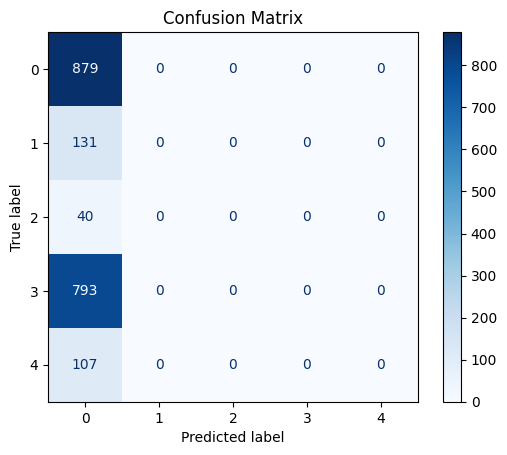

In [20]:
# Let's view the confusion matrix of test data
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The model assigned everything to the non-defect class. I was a bit worried about this, but thought that at least some of them would be assigned to the third class that had similar quantities. 

## Conclusion
The model I built radically overfits to the 0 class, or says that all images show no defects. The overall accuracy is 45%, but it's more useful to know that it's just assigning everything to no label. I was afraid of this given that some of the non-labeled images looked like they might be damaged. I also did not account for class imbalance within the models, so it really got out of hand. If I were to do this again I would strongly suggest using class weighting. I might also omit images that have a lot of black pixels.

Without digging into the specific accuracies, precision, and f1 scores of the Simple 3 Layered CNN versus the RESNET UNet pretrained model, the simple CNN had better loss reductions. However it may have been the case that the pretrained model did a better job of assigning images to classes other than 0, giving it a better accuracy or precision score.

Unfortunately this was not a model that could benefit the company by determining if steel sheets were damaged or not.